In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NLM
from src.utils import generate_data

In [2]:
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt

In [3]:
# def f(x, y, noise_var = 1.):
#     z = 10 * np.sin( 2 * np.sqrt(x ** 2 + y ** 2))
#     z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
#     return z_noise

def f(x, y, noise_var = 1.):
    z = x**3 + y**3
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise

# def f(x, y, noise_var = 1.):
#     z = 20 * ( np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x) )
#     z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
#     return z_noise


In [45]:
noise_var = 9.

# generate true contour
x1_true = np.linspace(-5., 5., 100)
x2_true = np.linspace(-5., 5., 100)

X1_true, X2_true = np.meshgrid(x1_true, x2_true)
Y_true = f(X1_true, X2_true, noise_var = 0.)

# generate x_train, y_train with a gap
x1_train = np.linspace(-4., 4., 30)
x2_train = np.linspace(-4., 4., 30)

X1, X2 = np.meshgrid(x1_train, x2_train)
gap_idx = np.logical_and(np.logical_and(X1 < 2., X1 > -2.), np.logical_and(X2 < 2., X2 > -2.))
# gap_idx = np.logical_and(X1 < 2., X1 > -2.)
Y = f(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
y = Y.flatten().reshape(1,-1)
print(x.shape,y.shape)

# make a slice
x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap
x2_fixed = x2_train[x2_fixed_idx] # extract the value
x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# generate x_test
x1_test = x1_true.copy()
x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
y_test_slice = f(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

(2, 704) (1, 704)


In [5]:
# noise_var = 1.

# # generate true contour
# x1_true = np.linspace(-4, 4, 100)
# x2_true = np.linspace(-4, 4, 100)

# X1_true, X2_true = np.meshgrid(x1_true, x2_true)
# Y_true = f(X1_true, X2_true, noise_var = 0.)

# # generate x_train, y_train with a gap
# x1_train = np.linspace(-3.25, 3.25, 30)
# x2_train = np.linspace(-3.25, 3.25, 30)

# X1, X2 = np.meshgrid(x1_train, x2_train)
# gap_idx = np.logical_and(np.logical_and(X1 < 1.25, X1 > -1.25),np.logical_and(X2 < 1.25, X2 > -1.25))
# Y = f(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

# x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
# y = Y.flatten().reshape(1,-1)
# print(x.shape,y.shape)

# # make a slice
# x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap
# x2_fixed = x2_train[x2_fixed_idx] # extract the value
# x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
# x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
# y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# # generate x_test
# x1_test = x1_true.copy()
# x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
# y_test_slice = f(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

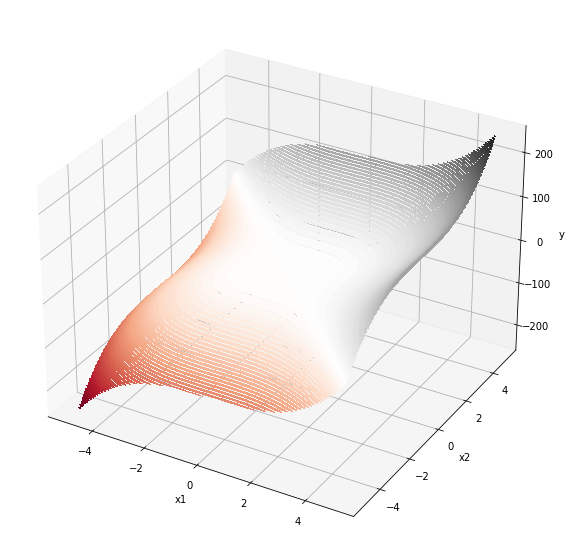

In [41]:
# Visualize ground truth of the function
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contourf(X1_true, X2_true, Y_true, 100, cmap='RdGy')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

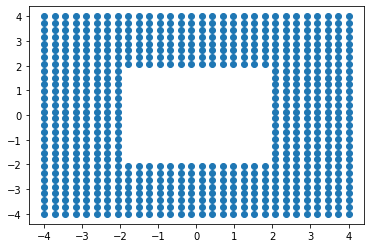

In [46]:
# plot x-y coordinate for training samples (with a gap)
plt.scatter(x[0,:],x[1,:])

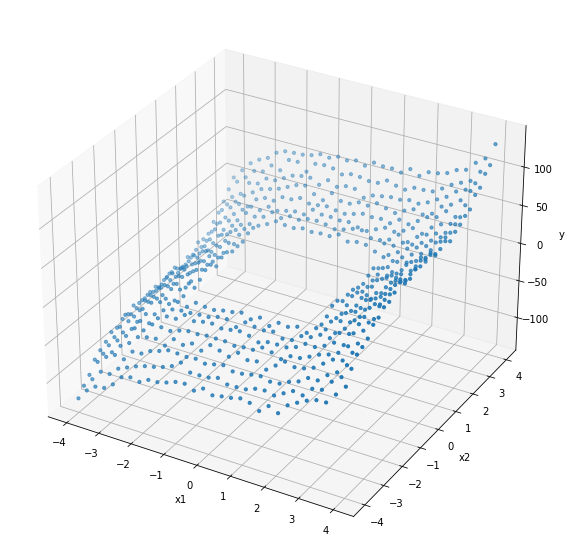

In [47]:
# Visualize training data
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x[0,:],x[1,:],y.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

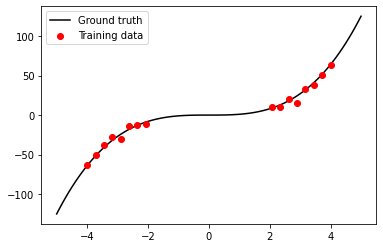

In [48]:
# visualize a slice over the 2-D function
plt.scatter(x_train_slice,y_train_slice,color='r',zorder = 100,label='Training data')
plt.plot(x_test[0,:],y_test_slice,'k',label='Ground truth')
plt.legend()
plt.show()

In [19]:
class LUNA(NLM):

    def __init__(self, architecture, random=None, weights=None):
        super(LUNA, self).__init__(architecture, random=random, weights=weights) # Inherit from NLM

        # Number of auxiliary functions to use
        self.params['M'] = architecture['auxiliary_functions']

        # Count number of parameters (weights + biases) in LUNA framework
        self.D_theta = self.D_in + self.D_hidden
        self.D_aux = self.params['M'] * self.D_out
        self.D = self.D_theta + self.D_aux # Total

        # Initiate model parameters (weights + biases)
        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            assert weights.shape == (1, self.D)
            self.weights = weights ## error?

        self.theta = self.weights[0][:self.D_theta]

        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x, return_features=False):
        """Forward pass for LUNA.

        Returns:
            output (numpy.array): Model predictions of shape (n_mod, n_param, n_obs).
        """

        assert weights.shape[1] == self.D

        # Obtain transformed features
        input = super(LUNA, self).forward(weights, x, return_features=True)

        # Return values from the last hidden layer if desired
        if return_features:
            return input # Shape: (n_mod, n_param, n_obs)

        # Set up for pass through output layer
        M = self.params['M'] # Number of auxiliary functions
        H = self.params['dim_hidden']
        dim_in = self.params['dim_in']
        dim_out = self.params['dim_out']
        index = self.D_theta
        weights = weights.T # Shape: (n_obs, n_param)

        # Pass through output layer
        W = weights[index:index + H[-1] * dim_out * M].T.reshape((M, dim_out, H[-1]))
        index += H[-1] * dim_out * M
        b = weights[index:].T.reshape((M, dim_out, 1))
        index += dim_out * M
        assert index == self.D
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['dim_out']

        return output
    


    def _finite_diff_grad(self, W_full, x_train):
        dim_in = self.params['dim_in']
        N = x_train.shape[1]
        
        std_del = 0.1
        delta_x = np.random.normal(0, std_del) # use one perturbation value for all x's
        
        if dim_in == 1:
            x_for = x_train + delta_x
            x_return = self.forward(W_full, x_for) -  self.forward(W_full, x_train)
            grad_FD = np.squeeze(np.divide(x_return, delta_x)) # M x N
            
        else: 
            x_train_rep = np.tile(x_train, (1, dim_in)) # make dim_in copies of x_train along dimension of datapoints
            x_perturb = np.tile(delta_x * np.eye(dim_in), (N, 1,1)) # create x_perturb
            x_perturb = x_perturb.T.reshape(dim_in, N * dim_in) # reshape x_perturb to form "blockwise" perturbation 

            x_for = x_train_rep + x_perturb
            x_return = self.forward(W_full, x_for) -  self.forward(W_full, x_train_rep)
            x_return = x_return.reshape(-1, dim_in, N) # reshape into M x dim_in x N

            grad_FD = x_return/delta_x # M x dim_in x N

        return grad_FD


    def _make_objective(self, x_train, y_train, reg_param=0, lambda_in=0):
        M = self.params['M']

        def objective(W_full, t):
            # Compute L_fit
            y_train_rep = np.tile(y_train, (M,1,1)) # repeat y_train with shape = dim_out x n_sample to M x dim_out x n_sample
            squared_error = np.linalg.norm(y_train_rep - self.forward(W_full, x_train), axis=1)**2
            L_fit = np.mean(squared_error) + reg_param * np.linalg.norm(W_full)

            # Comput L_diverse (#### Only works for dim_out = 1 ####)
            if self.params['dim_in'] == 1:
                grad_FD = self._finite_diff_grad(W_full, x_train) # reshape to M x num of samples
                grad_angle = np.arctan(grad_FD) # compute the "angle of those gradients"
                grad_angle_rep = np.tile(grad_angle,(M,1,1)) # repeate the matrix to create M x M x num of samples
                grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
                coSimSqMat = np.mean(np.cos(grad_angle_rep - grad_angle_rep_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints
            else: 
                grad_FD = self._finite_diff_grad(self.weights, x_train) # M x dim_in x num of samples
                norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
                norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
                coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints
                # documentation for np.einsum (with broadcasting): see https://numpy.org/doc/stable/reference/generated/numpy.einsum.html#numpy.einsum
            
            coSimSq_uniq_pair = coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)] # taking the upper triagular part
            L_diverse = np.sum(coSimSq_uniq_pair)
#             L_diverse = np.sum(coSimSq_uniq_pair[np.random.choice(coSimSq_uniq_pair.shape[0],size = int(0.3*coSimSq_uniq_pair.shape[0]),replace=False)])

            return L_fit + lambda_in * L_diverse  # punish when coSimSq is large (close to 1)

        return objective, grad(objective)


    def fit(self, x_train, y_train, params):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['dim_in']
        assert y_train.shape[0] == self.params['dim_out']

        # Make objective function for training
        reg_param = params.get('reg_param', 0) # No regularization by default
        lambda_in = params.get('lambda_in', 0) # No diversity training by default
        objective, gradient = self._make_objective(x_train, y_train, reg_param, lambda_in)

        # Train model
        self._fit(objective, gradient, params)

        # Save feature map
        self.theta = self.weights[0][:self.D_theta]



## LUNA

In [115]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.exp(-x**2)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 2
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 50,
}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a NN with LUNA
luna = LUNA(architecture, random=random)
print('Number of parameters =',luna.D)

Number of parameters = 5250


### Inspect coSim^2 before fitting

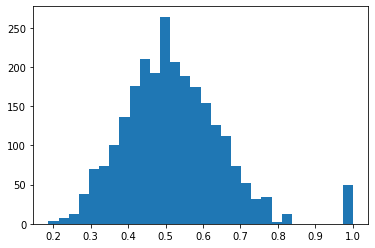

In [116]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions before fitting

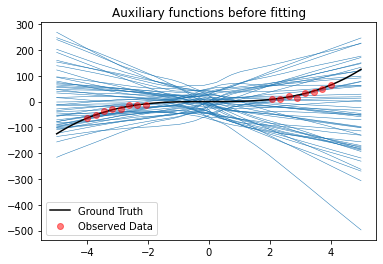

In [117]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions before fitting')
plt.legend()
plt.show()

### Fit LUNA

In [118]:
### define design choices in gradient descent
params = {
    'step_size':1e-3,
    'max_iteration':5000,
    'random_restarts':1,
    'reg_param':0.01,
    'lambda_in':10.,
}

# fit LUNA
luna.fit(x, y, params)

Iteration 0 loss 20665.092639819937; gradient mag: 5422.774418317664
Iteration 100 loss 10622.675614282245; gradient mag: 1863.884007347706
Iteration 200 loss 7947.742809828569; gradient mag: 785.6375284901058
Iteration 300 loss 6965.426118653382; gradient mag: 326.4786581292678
Iteration 400 loss 6679.376455608862; gradient mag: 152.1853935090704
Iteration 500 loss 6584.749296498528; gradient mag: 91.43884906495465
Iteration 600 loss 6538.306852218849; gradient mag: 65.34437497417593
Iteration 700 loss 6509.0602378036265; gradient mag: 52.179529002244124
Iteration 800 loss 6486.831419572582; gradient mag: 44.78680529238258
Iteration 900 loss 6467.004486468433; gradient mag: 39.517215518606044
Iteration 1000 loss 6451.506193921348; gradient mag: 37.23032306487636
Iteration 1100 loss 6420.577477819586; gradient mag: 33.47442922650347
Iteration 1200 loss 6399.871093687189; gradient mag: 29.644563964363112
Iteration 1300 loss 6370.64694579135; gradient mag: 24.895462494624752
Iteration 14

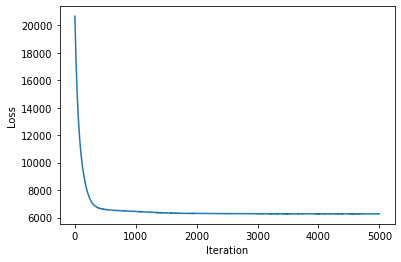

In [119]:
plt.plot(luna.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect coSim^2 after fitting

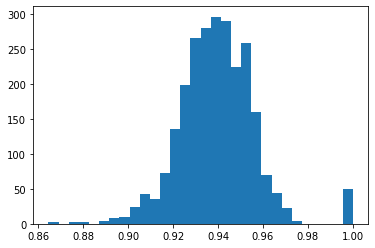

In [120]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30);

### Inspect auxiliary functions after fitting

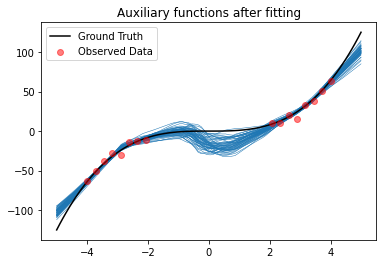

In [121]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions after fitting')
plt.legend()
plt.show()

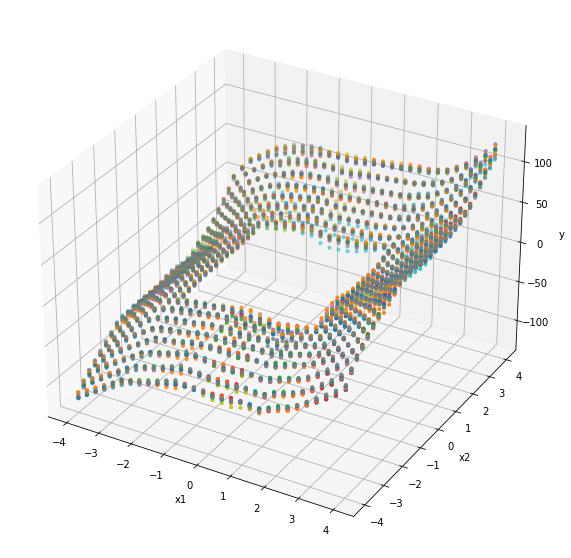

In [122]:
y_pred = luna.forward(luna.weights, x)
y_pred.shape

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for i in range(10):    
    ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred[i,0,:], s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

### Display prior samples

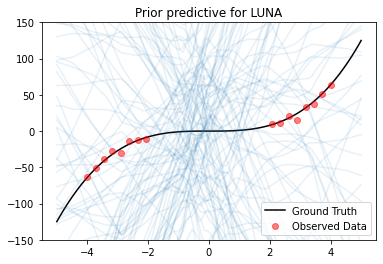

In [123]:
prior_mean = 0
prior_var = 25.
# noise_var = 9.
y_prior = luna.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
# plt.ylim([-15, 15])
plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior samples

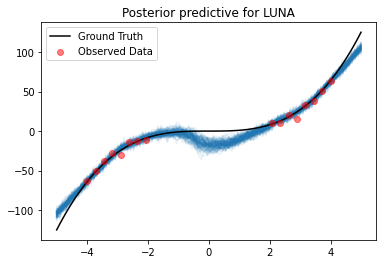

In [124]:
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, zorder = 0,color='tab:blue', alpha=0.1)
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

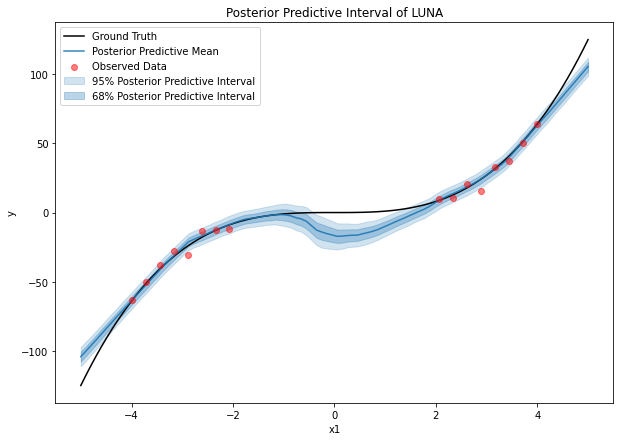

In [125]:
# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

## NLM

In [92]:
# instantiate an NLM with same architecture 
nlm = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

# params = {
#     'step_size':1e-3,
#     'max_iteration':4000,
#     'random_restarts':1,
#     'reg_param':10.,
#     'lambda_in':1.,
# }

nlm.fit(x,y, params)

Number of parameters = 2751
Iteration 0 loss 20098.62509844576; gradient mag: 23716.44347859536
Iteration 100 loss 756.1411836469105; gradient mag: 2479.246779302142
Iteration 200 loss 309.97173674401176; gradient mag: 384.12303359284164
Iteration 300 loss 230.0122357271636; gradient mag: 168.58782300265574
Iteration 400 loss 200.64974471892785; gradient mag: 123.49228360302244
Iteration 500 loss 174.988335900297; gradient mag: 119.91854895116553
Iteration 600 loss 152.2568806931338; gradient mag: 89.6497998576634
Iteration 700 loss 135.96539631098764; gradient mag: 76.24496919535143
Iteration 800 loss 119.74591481774276; gradient mag: 70.3555289895167
Iteration 900 loss 105.37564015237425; gradient mag: 67.3854711535452
Iteration 1000 loss 94.77786548636628; gradient mag: 57.50818559668945
Iteration 1100 loss 87.35633844159106; gradient mag: 49.99940698994978
Iteration 1200 loss 82.69365058256325; gradient mag: 35.00455315617151
Iteration 1300 loss 79.68291709078335; gradient mag: 27.

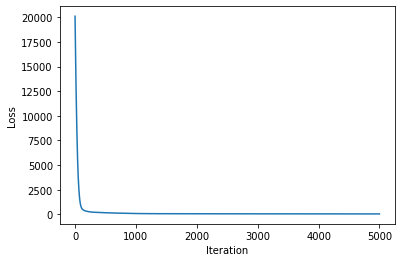

In [93]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect MLE fit

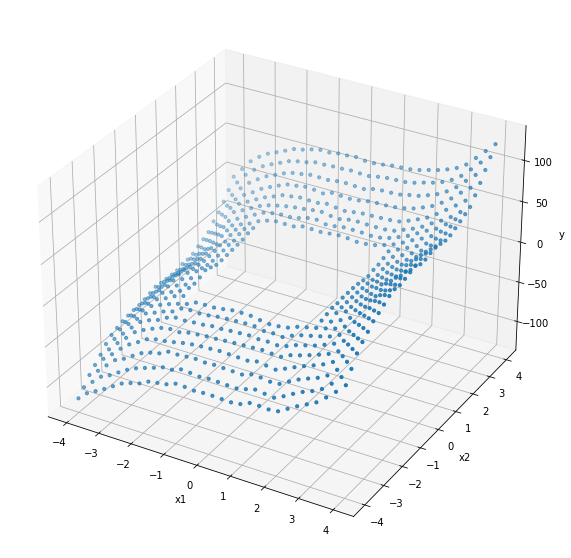

In [94]:
y_pred = nlm.forward(nlm.weights, x)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred.flatten(), s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

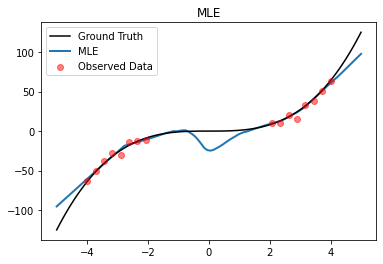

In [95]:
y_pred = nlm.forward(nlm.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 2, alpha=1, zorder = 0,color='tab:blue',label='MLE')
plt.title('MLE')
plt.legend()
plt.show()

### Display prior samples

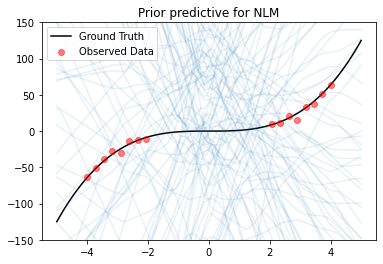

In [96]:
prior_mean = 0
prior_var = 25.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
# plt.ylim([-15, 15])
plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

### Display posterior samples

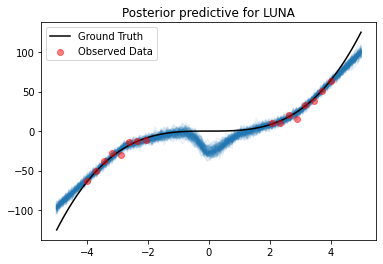

In [97]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape) 

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1,zorder=0)
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

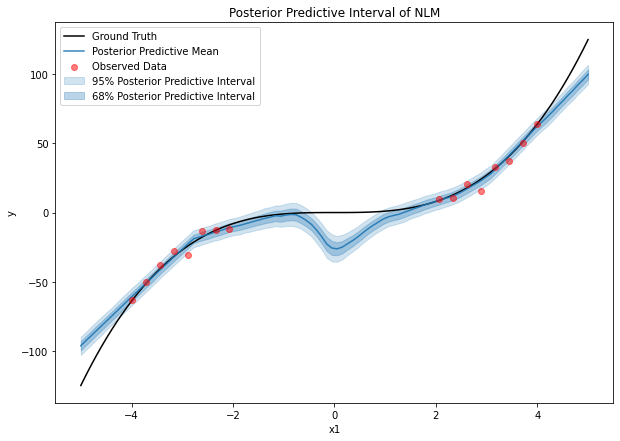

In [98]:
# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()

In [62]:
x, y, x_test = generate_data(number_of_points=20, noise_variance=9, input_dimension=2)

In [63]:
# instantiate an NLM with same architecture 
nlm2 = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

params2 = {
    'step_size':1e-3,
    'max_iteration':5000,
    'random_restarts':1,
    'reg_param':10.,
    'lambda_in':10.
}

nlm2.fit(x,y, params2)

Number of parameters = 2751
Iteration 0 loss 14282.356121127486; gradient mag: 33378.5787652579
Iteration 100 loss 972.2951845641346; gradient mag: 317.45575830248845
Iteration 200 loss 877.3894495578153; gradient mag: 241.92508755308782
Iteration 300 loss 777.0358258539204; gradient mag: 213.26963493882516
Iteration 400 loss 688.0116228536207; gradient mag: 176.92147342455928
Iteration 500 loss 612.2998505432757; gradient mag: 147.3209584651073
Iteration 600 loss 552.3345196281273; gradient mag: 119.16945586301377
Iteration 700 loss 508.9560735508719; gradient mag: 91.53891427310734
Iteration 800 loss 480.4376086874746; gradient mag: 65.82834735261699
Iteration 900 loss 460.55781871865275; gradient mag: 53.61954666121197
Iteration 1000 loss 447.9723249104285; gradient mag: 52.65191795176955
Iteration 1100 loss 437.26171690459535; gradient mag: 49.20051396969644
Iteration 1200 loss 428.1884350208732; gradient mag: 40.27401807070423
Iteration 1300 loss 420.11956713433096; gradient mag: 

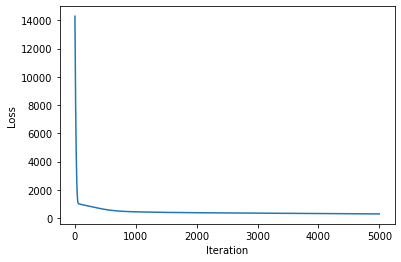

In [64]:
plt.plot(nlm2.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

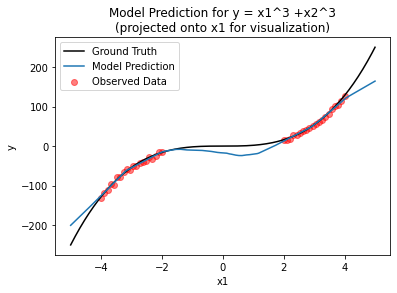

In [65]:
y_pred = nlm2.forward(nlm2.weights, x_test)
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_pred.flatten(), color='tab:blue', label="Model Prediction")
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Model Prediction for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

In [66]:
prior_mean = 0
prior_var = 1.
# noise_var = 9.

y_prior = nlm2.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

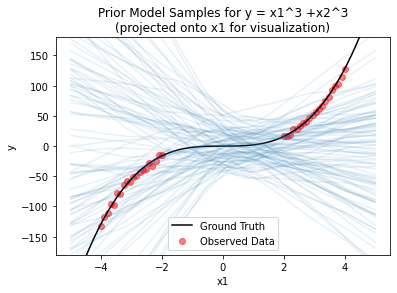

In [67]:
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-180, 180])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Prior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

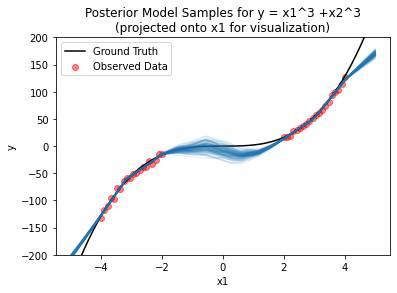

In [68]:
y_posterior = nlm2.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-200, 200])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Posterior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

In [69]:
# instantiate an NLM with same architecture 
luna2 = LUNA(architecture, random=random)
print('Number of parameters =', luna.D)

# params = {
#     'step_size':1e-3,
#     'max_iteration':5000,
#     'random_restarts':1,
#     'reg_param':10.,
#     'lambda_in':10.,
# }

luna2.fit(x,y, params2)

Number of parameters = 5250
Iteration 0 loss 28171.252460726657; gradient mag: 9600.34321162914
Iteration 100 loss 13105.708164923046; gradient mag: 3190.4906188925456
Iteration 200 loss 9313.098134431446; gradient mag: 1314.1346616521394
Iteration 300 loss 8042.353794671188; gradient mag: 605.7518698445127
Iteration 400 loss 7617.442512616308; gradient mag: 292.6570938697457
Iteration 500 loss 7480.934146514461; gradient mag: 145.8636978485652
Iteration 600 loss 7416.306669025836; gradient mag: 73.1178313151674
Iteration 700 loss 7415.6783900342125; gradient mag: 52.31270435058016
Iteration 800 loss 7304.317294349881; gradient mag: 47.91393147751543
Iteration 900 loss 7255.971930466894; gradient mag: 44.771133636219545
Iteration 1000 loss 7171.457883612504; gradient mag: 46.991967284252695
Iteration 1100 loss 7186.706956568132; gradient mag: 35.452601888204434
Iteration 1200 loss 7097.9113933321205; gradient mag: 31.569615768076645
Iteration 1300 loss 7059.376129857238; gradient mag: 

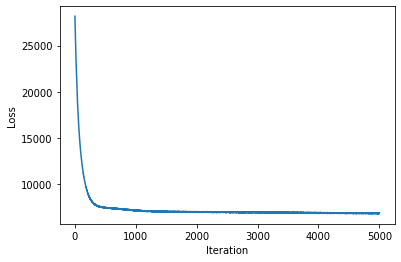

In [70]:
plt.plot(luna2.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

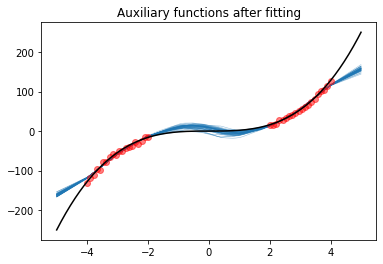

In [71]:
y_pred = luna2.forward(luna2.weights, x_test)
np.squeeze(y_pred).T.shape, x_test[0,:].T.shape

plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:].T, np.squeeze(y_pred).T, color='tab:blue',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions after fitting')
plt.show()


In [72]:
prior_mean = 0
prior_var = 1.
# noise_var = 9.

y_prior = luna2.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

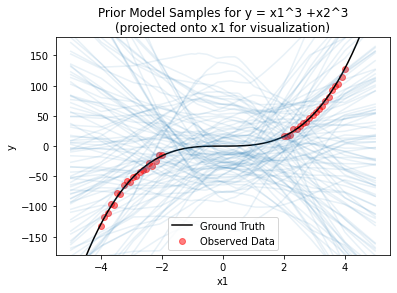

In [73]:
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-180, 180])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Prior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

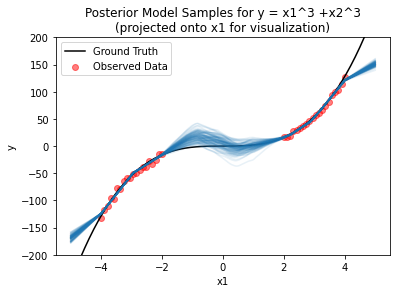

In [74]:
y_posterior = luna2.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-200, 200])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Posterior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()